In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader


import matplotlib.pyplot as plt
# Logger
from torch.utils.tensorboard import SummaryWriter

# Level Check
import LevelChecker

# GeneratorPreview
import visualizer
from torchinfo import summary

# Makedirs
import os

# Core Functions

## Characters
mapeo_caracteres = {'X': 0, 'S': 1, '-': 2, '?': 3, 'Q': 4, 'E': 5, '<': 6, '>': 7, '[': 8, ']': 9, 'o': 10, 'B': 11, 'b': 12}
mapeo_caracteres_inverso = {valor: clave for clave, valor in mapeo_caracteres.items()}
map_number = len(mapeo_caracteres.keys())
dataRGBrange = [ 255/(map_number-1) * i for i in range(map_number)]

def closer_number(value_list, target_value):
    return min(value_list, key=lambda x: abs(x - target_value))


def convertToCharacters(sample, data = dataRGBrange):
    mapped_img = np.vectorize(lambda x: closer_number(data, x))(sample)
    char_img = np.vectorize(lambda x: mapeo_caracteres_inverso[data.index(x)])(mapped_img)
    return char_img
    

def visualize_mario_sample(samples, labels=None, num_samples=16, figsize=(10, 10), debug=False):
    """
    Visualize generated Mario samples
    
    Args:
        samples: numpy array of shape (num_samples, 1, 14, 14)
        labels: optional list of corresponding labels
        num_samples: number of samples to visualize
        figsize: size of the figure
    """
    # Verify that num_samples is a perfect square
    n = int(num_samples ** 0.5)
    assert n * n == num_samples, "num_samples must be a perfect square"
    
    fig, axes = plt.subplots(n, n, figsize=figsize)

    imagesToReturn = []
    for i in range(n):
        for j in range(n):
            idx = i * n + j
            # Convert grayscale image to character matrix
            img = samples[idx, 0]
            char_img = np.vectorize(lambda x: mapeo_caracteres_inverso[dataRGBrange.index(closer_number(dataRGBrange, x))])(img)
            
            # Generate preview image from character matrix
            preview_img = visualizer.generar_preview(char_img)
            imagesToReturn.append(preview_img)
            
            # Display the preview image
            axes[i, j].imshow(preview_img, vmin=0, vmax=255)
            axes[i, j].axis('off')
            
            # Add label if provided
            if labels is not None:
                axes[i, j].set_title(f'Label: {labels[idx]}')
    
    plt.tight_layout()
    plt.show()

    if debug:
        # Count pixel values
        pixel_counts_list = count_pixel_values_per_image(samples)
        for idx, pixel_counts in enumerate(pixel_counts_list):
            print(f"Image {idx + 1} Pixel Value Counts:")
            for pixel, count in sorted(pixel_counts.items()):
                print(f"  {pixel}: {count}")
            print()
    return imagesToReturn


# Bootstrapping


# EVALUATE GENERATED MAPS
def BoostrappingMaps(maps, debug_results=False, debug_visualize=False, saveImg=False, savepath='./', epoch=''):
    
    valid_maps = []
    
    for idx, sample in enumerate(maps):
        char_img = convertToCharacters(sample)
        
        # Test maps
        mapavalido, salidas = LevelChecker.probar_mapa(char_img)
        primera_columna_valida = LevelChecker.verificar_primera_columna(char_img)
        bloques_pregunta_validos = LevelChecker.verificar_bloques_pregunta(char_img)
        camino_valido = LevelChecker.a_star(char_img)

        if mapavalido and primera_columna_valida and bloques_pregunta_validos and camino_valido:
            valid_maps.append(char_img)
            if debug_results:
                print(f"Map {idx + 1} passed all tests.")
                print("Outputs:", salidas)
    
    generatedimages = None
    if debug_visualize and valid_maps :
        generatedimages = visualize_mario_sample(valid_maps, num_samples=len(maps), debug=False)
        
    if saveImg:
        for idx, sample in enumerate(valid_maps):
            plt.imsave(f"{savepath}/generated_image_{epoch}_{idx + 1}.png", sample, cmap='gray', vmin=0, vmax=255)
    
    return valid_maps



LevelChecker


In [2]:

class PixelDataset(Dataset):
    def __init__(self, csv_path, transform=None, balance=False):
        """
        Args:
            csv_path (str): Path to the CSV file
            transform (callable, optional): Optional transformations
        """
        # Load CSV, first column is label, rest are pixels
        self.data = pd.read_csv(csv_path)
        
        # Encontrar la cantidad mínima de muestras entre las clases
        if (balance):
            min_samples = self.data['label'].value_counts().min()
            self.data =  self.data.groupby('label').apply(lambda x: x.sample(n=min_samples)).reset_index(drop=True)
        
        self.pixels = self.data.iloc[:, 1:].values  # All pixels except label
        self.labels = self.data.iloc[:, 0].values   # Labels

        # Encontrar la cantidad mínima de muestras entre las clases
        min_samples = self.data['label'].value_counts().min()
        
        # Subsamplear cada clase
        balanced_data = self.data.groupby('label').apply(lambda x: x.sample(n=min_samples)).reset_index(drop=True)
        
        self.transform = transform
        print("Clases únicas:", self.data['label'].unique())
        print("Distribución de clases:\n", self.data['label'].value_counts())
        
        print("Clases únicas:", balanced_data['label'].unique())
        print("Distribución de clases:\n", balanced_data['label'].value_counts())
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        # Get pixels and reshape to 14x14
        pixels = self.pixels[idx].reshape(14, 14).astype(np.float32)
        # Normalize values to [-1, 1]
        pixels = (pixels / 127.5) - 1
        
        # Convert to tensor
        pixels = torch.FloatTensor(pixels)
        # Add channel dimension
        pixels = pixels.unsqueeze(0)
        
        # Get label
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        
        if self.transform:
            pixels = self.transform(pixels)
            
        return pixels, label

In [3]:
class ConditionalGenerator(nn.Module):
    def __init__(self, latent_dim=100, num_classes=3, ngf=64):
        super(ConditionalGenerator, self).__init__()
        
        self.label_emb = nn.Embedding(num_classes, num_classes)
        
        concat_dim = latent_dim + num_classes
        
        self.main = nn.Sequential(
            # Input: (latent_dim + num_classes) x 1 x 1
            nn.ConvTranspose2d(concat_dim, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # State: (ngf*8) x 4 x 4
            
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 3, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # State: (ngf*4) x 7 x 7
            
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # State: (ngf*2) x 14 x 14
        )
        
        self.final = nn.Sequential(
            nn.Conv2d(ngf * 2, 1, 1, 1, 0, bias=False),
            nn.Tanh()
            # Output: 1 x 14 x 14
        )
        
    def forward(self, z, labels):
        label_embedding = self.label_emb(labels)
        
        label_embedding = label_embedding.view(label_embedding.size(0), -1, 1, 1)
        
        x = torch.cat([z, label_embedding], dim=1)
        
        x = self.main(x)
        return self.final(x)

In [4]:
class ConditionalDiscriminator(nn.Module):
    def __init__(self, num_classes=3, ndf=64):
        super(ConditionalDiscriminator, self).__init__()
        
        # Embedding for labels
        self.label_emb = nn.Embedding(num_classes, num_classes)
        
        self.main = nn.Sequential(
            # Input: 1 x 14 x 14
            nn.Conv2d(1, ndf * 2, 3, 2, 1, bias=False),
            nn.LayerNorm([ndf * 2, 7, 7]),
            nn.LeakyReLU(0.2, inplace=True),
            # State: (ndf*2) x 7 x 7
        )
        
        self.final = nn.Sequential(
            nn.Conv2d(ndf * 2, ndf * 4, 3, 2, 1, bias=False),
            nn.LayerNorm([ndf * 4, 4, 4]),
            nn.LeakyReLU(0.2, inplace=True),
            # State: (ndf*4) x 4 x 4
        )
        
        self.output = nn.Sequential(
            nn.Linear(ndf * 4 * 4 * 4 + num_classes, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x, labels):
        x = self.main(x)
        x = self.final(x)
    
        x = x.view(x.size(0), -1)
        
        label_embedding = self.label_emb(labels)
        
        x = torch.cat([x, label_embedding], dim=1)
        
        # Final classification
        return self.output(x).squeeze()

In [5]:
def train_conditional_model(csv_path, num_epochs=100, batch_size=64, lr=0.00015, beta1=0.5, SaveEachEpochs = 100, SavePath = "Checkpoints/SAGAN", SaveModelName = "/SAGANModel", ShouldLoadModel = False):
    
    os.makedirs(os.path.dirname(SavePath), exist_ok=True)
    print("savepath",SavePath)
    # Save parameters to a text file
    with open(f"{SavePath}training_parameters.txt", "w") as f:
        f.write(f"csv_path: {csv_path}\n")
        f.write(f"num_epochs: {num_epochs}\n")
        f.write(f"batch_size: {batch_size}\n")
        f.write(f"lr: {lr}\n")
        f.write(f"beta1: {beta1}\n")
        f.write(f"SaveEachEpochs: {SaveEachEpochs}\n")
        f.write(f"SaveModelName: {SaveModelName}\n")
        f.write(f"ShouldLoadModel: {ShouldLoadModel}\n")
    
    # Set up device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Create dataset and dataloader
    dataset = PixelDataset(csv_path)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    
    # Number of classes
    num_classes = len(np.unique(dataset.labels))
    print("number of classes:", num_classes)
    
    # Models Params
    # Initial parameter
    model_ngf = 64
    # model_ngf = 128
    model_ndf = model_ngf
    # Initialize models
    netG = ConditionalGenerator(num_classes=num_classes, ngf=model_ngf).to(device)
    netD = ConditionalDiscriminator(num_classes=num_classes, ndf=model_ndf).to(device)
    
    # Loss and optimizers
    criterion = nn.BCELoss()
    optimizerD = torch.optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
    optimizerG = torch.optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))
    
    # Logger Tensorboard
    writer = SummaryWriter()

    # Save Model
    
    
    actualepoch = -1
    # Training loop
    if not ShouldLoadModel:
        for epoch in range(num_epochs):
            for i, (real_images, labels) in enumerate(dataloader):
                batch_size = real_images.size(0)
                real_images, labels = real_images.to(device), labels.to(device)
                
                # Discriminator training
                netD.zero_grad()
                
                # Real images
                real_label = torch.ones(batch_size, device=device)
                output = netD(real_images, labels)
                errD_real = criterion(output, real_label)
                errD_real.backward()
                
                # Fake images
                noise = torch.randn(batch_size, 100, 1, 1, device=device)
                fake_label = torch.zeros(batch_size, device=device)
                fake_images = netG(noise, labels)

                ## Image Show and saving
                                
                # Draw
                if epoch % 5 ==0:
                    if (actualepoch != epoch):
                        actualepoch = epoch
                        visualize_mario_sample(fake_images.cpu().squeeze(1).detach().numpy()[0:9], num_samples=9, figsize=(3, 3), debug=False)


                #####
                output = netD(fake_images.detach(), labels)
                errD_fake = criterion(output, fake_label)
                errD_fake.backward()
                
                errD = errD_real + errD_fake
                optimizerD.step()
    
                # Generator training
                netG.zero_grad()
                output = netD(fake_images, labels)
                errG = criterion(output, real_label)
                errG.backward()
                optimizerG.step()
                
                # Print training stats
                if i % 50 == 0:
                    print(f'Epoch [{epoch}/{num_epochs}] Batch [{i}/{len(dataloader)}] '
                          f'D_loss: {errD.item():.4f}, G_loss: {errG.item():.4f}')
                    
                BoostrappingMaps(fake_images.cpu().squeeze(1).detach().numpy(),
                                 labels, 
                                 debug_visualize=True, 
                                 saveImg=True,
                                 savepath='./SavedImages', 
                                 epoch=f'{epoch}'
                                )

                # Save model
                if (epoch + 1) % SaveEachEpochs == 0:
                    torch.save(netG.state_dict(), f'{SavePath+SaveModelName}Gen{epoch+1}.pth')
                
                # Write on Tensorboard
                writer.add_scalar("Loss/train G", errG, epoch)
                writer.add_scalar("Loss/train D", errD, epoch)
                writer.add_scalar("Loss/train D_real", errD_real, epoch)
                writer.add_scalar("Loss/train D_fake", errD_fake, epoch)

    writer.flush()
    return netG, netD

In [6]:
# shouldTrain = True
shouldTrain = False
if shouldTrain:
    # Example usage
    csv_path = './dataset/mario_train.csv'  # Replace with actual path
    
    # Train conditional GAN
    generator, discriminator = train_conditional_model(
        csv_path=csv_path,
        num_epochs=1000,
        batch_size=64,
        SaveEachEpochs = 100,
        SavePath = "Checkpoints/SAGANTest0Bootstrapping/",
        SaveModelName = "SAGANModel", 
        ShouldLoadModel = False
        
    )
    print("finisco")
    

In [7]:
def generate_conditional_samples(generator, labels, device='cuda'):
    """
    Generate samples for specific labels
    
    Args:
        generator (nn.Module): Trained generator
        labels (list or torch.Tensor): List of labels to generate
        device (str): Device to run generation on
    
    Returns:
        numpy array of generated images
    """
    with torch.no_grad():
        # Create noise vector
        batch_size = len(labels)
        noise = torch.randn(batch_size, 100, 1, 1, device=device)
        
        # Convert labels to tensor if not already
        labels = torch.tensor(labels, device=device)
        
        # Generate images
        generated = generator(noise, labels)
        
        # Denormalize images
        generated = (generated + 1) * 127.5
        return generated.cpu().numpy()



def visualize_samples(samples, labels=None, num_samples=16, figsize=(10, 10), debug = False):
    """
    Visualize generated samples
    
    Args:
        samples: numpy array of shape (num_samples, 1, 14, 14)
        labels: optional list of corresponding labels
        num_samples: number of samples to visualize
        figsize: size of the figure
    """
    # Verify that num_samples is a perfect square
    n = int(num_samples ** 0.5)
    assert n * n == num_samples, "num_samples must be a perfect square"
    
    fig, axes = plt.subplots(n, n, figsize=figsize)
    
    for i in range(n):
        for j in range(n):
            idx = i * n + j
            # Map each pixel to its closest value in dataRGBrange
            img = samples[idx, 0]
            mapped_img = np.vectorize(lambda x: closer_number(dataRGBrange, x))(img)
            
            # Display the modified image
            axes[i, j].imshow(mapped_img, cmap='gray', vmin=0, vmax=255)
            axes[i, j].axis('off')
            
            # Add label if provided
            if labels is not None:
                axes[i, j].set_title(f'Label: {labels[idx]}')
    
    plt.tight_layout()
    plt.show()

    if (debug):
        # Count pixel values
        pixel_counts_list = count_pixel_values_per_image(samples)
        for idx, pixel_counts in enumerate(pixel_counts_list):
            print(f"Image {idx + 1} Pixel Value Counts:")
            for pixel, count in sorted(pixel_counts.items()):
                print(f"  {pixel}: {count}")
            print()


def visualize_samplesTrail(samples, labels=None, num_samples=16, figsize=(10, 10), debug=False):
    """
    Visualize generated samples
    
    Args:
        samples: numpy array of shape (num_samples, 1, 14, 14)
        labels: optional list of corresponding labels
        num_samples: number of samples to visualize
        figsize: size of the figure
    """
    # Verify that num_samples is a perfect square
    n = int(num_samples ** 0.5)
    assert n * n == num_samples, "num_samples must be a perfect square"
    
    fig, axes = plt.subplots(n, n, figsize=figsize)
    
    concatenated_images = []
    
    for i in range(n):
        row_images = []
        for j in range(n):
            idx = i * n + j
            # Map each pixel to its closest value in dataRGBrange
            img = samples[idx, 0]
            mapped_img = np.vectorize(lambda x: closer_number(dataRGBrange, x))(img)
            row_images.append(mapped_img)
            
        # Display the modified image
        axes[i, j].imshow(mapped_img, cmap='gray', vmin=0, vmax=255)
        axes[i, j].axis('off')
            
        # Add label if provided
        if labels is not None:
            axes[i, j].set_title(f'Label: {labels[idx]}')
        
        concatenated_images.append(np.concatenate(row_images, axis=1))
    
    concatenated_image = np.concatenate(concatenated_images, axis=0)
    
    plt.tight_layout()
    plt.show()

    if debug:
        # Count pixel values
        pixel_counts_list = count_pixel_values_per_image(samples)
        for idx, pixel_counts in enumerate(pixel_counts_list):
            print(f"Image {idx + 1} Pixel Value Counts:")
            for pixel, count in sorted(pixel_counts.items()):
                print(f"  {pixel}: {count}")
            print()
    
    return concatenated_image



# Debug
from collections import Counter
def count_pixel_values_per_image(samples, rounding_factor=21.25):
    """
    Count pixel values and their occurrences in a batch of images.
    
    Args:
        samples: numpy array of shape (num_samples, 1, 14, 14)
    
    Returns:
        A dictionary with pixel values as keys and their counts as values.
    """
    pixel_counts_list = []
    
    for img_idx in range(samples.shape[0]):
        # Flatten the current image, round values, and count pixel values
        flat_pixels = samples[img_idx, 0].flatten()
        rounded_pixels = np.round(flat_pixels / rounding_factor) * rounding_factor  # Round to nearest multiple
        pixel_counts = Counter(rounded_pixels)
        pixel_counts_list.append(pixel_counts)
    
    return pixel_counts_list

# EVALUATE GENERATED MAPS
def evaluate_generated_maps(generator, num_samples=100, labels=None, seed=None, debug=False, debug_results=False, debug_visualize=False, debug_count=False, saveImg=False, savepath='./', label=''):
    """
    Evaluate the generated maps
    
    Args:
        generator (nn.Module): Trained generator
        num_samples (int): Number of samples to generate
        labels: optional list of corresponding labels
        seed: Seed value for reproducibility
        debug: flag to print detailed debug information
        debug_results: flag to print only the results of map validation
        debug_visualize: flag to visualize generated samples
        debug_count: flag to print pixel value counts
        saveImg: flag to save generated images
        savepath: path to save generated images
        label: additional label to add to the image filename
    """
    # Set the seed for reproducibility
    if seed is not None:
        np.random.seed(seed)  # Set seed for numpy
        torch.manual_seed(seed)  # Set seed for PyTorch
    
    # If no labels are provided, generate random labels
    if labels is None:
        labels = np.random.randint(0, 3, num_samples)  # Assuming 3 classes for labels
    
    # Sort samples and labels by label
    sorted_indices = np.argsort(labels)
    labels = labels[sorted_indices]
    # Generate samples
    generated_samples = generate_conditional_samples(generator, labels)
    
    # Initialize list to store validity of maps
    map_validity = []
    first_column_validity = []
    block_question_validity = []
    pathfinding_validity = []
    
    originality_validity = LevelChecker.originalidad(generated_samples,label=label,size = num_samples)

    print("num_samples:      ",num_samples)
    # Convert each pixel to the closest value in dataRGBrange and then to a character
    for idx, sample in enumerate(generated_samples):
        img = sample[0]
        char_img = convertToCharacters(img)
        
        if debug:
            print(f"Generated Map {idx + 1}:")
            for row in char_img:
                print("".join(row))
            print()

        # Probar el mapa
        mapavalido, salidas = LevelChecker.probar_mapa(char_img)
        map_validity.append(mapavalido)

        # Verificar primera columna
        primera_columna_valida = LevelChecker.verificar_primera_columna(char_img)
        first_column_validity.append(primera_columna_valida)

        # Verificar bloques pregunta
        bloques_pregunta_validos = LevelChecker.verificar_bloques_pregunta(char_img)
        block_question_validity.append(bloques_pregunta_validos)

        # Verificar pathfinding
        camino_valido = LevelChecker.a_star(char_img)
        pathfinding_validity.append(camino_valido)


        if debug or debug_results:
            if mapavalido:
                print(f"Map {idx + 1} is valid.")
            else:
                print(f"Map {idx + 1} is not valid.")
            print("Outputs:", salidas)
    
    generatedimages = None
    # Visualize samples if debug_visualize is True
    if debug_visualize:
        labels_with_validity = [f"{label} {'T' if valid else 'F'}" for label, valid in zip(labels, map_validity)]
        generatedimages = visualize_mario_sample(generated_samples, labels_with_validity, num_samples=num_samples, debug=debug_count)
        
    # Save images if saveImg is True
    if saveImg:
        for idx, sample in enumerate(generated_samples):
            img = sample[0]
            plt.imsave(f"{savepath}/generated_image_{label}_{idx + 1}.png", img, cmap='gray', vmin=0, vmax=255)
    
    # Count pixel values
    pixel_counts_list = count_pixel_values_per_image(generated_samples)
    for idx, pixel_counts in enumerate(pixel_counts_list):
        if debug or debug_count:
            print(f"Image {idx + 1} Pixel Value Counts:")
            for pixel, count in sorted(pixel_counts.items()):
                print(f"  {pixel}: {count}")
            print()

    # Print statistics
    print("Verificación | Cuantos cumplen | Cuantos no cumplen")
    print(f"Primer bloque | {sum(first_column_validity)} | {len(first_column_validity) - sum(first_column_validity)}")
    print(f"Bloques funcionales | {sum(block_question_validity)} | {len(block_question_validity) - sum(block_question_validity)}")
    print(f"Camino valido| {sum(pathfinding_validity)} | {len(pathfinding_validity) - sum(pathfinding_validity)}")
    print(f"Originalidad | {sum(originality_validity)} | {len(originality_validity) - sum(originality_validity)}")

    # Print IDs of maps that passed all tests and save their images
    for idx, (map_valid, first_col_valid, block_q_valid, path_valid) in enumerate(zip(map_validity, first_column_validity, block_question_validity, pathfinding_validity)):
        if map_valid and first_col_valid and block_q_valid and path_valid:
            print(f"Map {idx + 1} passed all tests.")
            img = generated_samples[idx][0]
            plt.imsave(f"{savepath}/generated_tosaveimage_{label}_{idx + 1}.png", img, cmap='gray', vmin=0, vmax=255)
        if saveImg:
            img = generatedimages[idx][0]
            plt.imsave(f"{savepath}/generated_image_{label}_{idx + 1}.png", img, cmap='gray', vmin=0, vmax=255)



print("Finisco le definizione")




Finisco le definizione


In [8]:

if shouldTrain:
# Generate samples for specific labels
# labels_to_generate = [0, 1, 2, 0, 1, 2, 0, 1, 2]
# labels_to_generate = [i%3 for i in range(9) ]  
    labels_to_generate = [0 for i in range(9) ]  
    print(labels_to_generate)
    generated_samples = generate_conditional_samples(generator, labels_to_generate)
    
    # Visualize generated samples
    visualize_mario_sample(samples=generated_samples, labels=labels_to_generate, num_samples=9)

In [9]:

if not shouldTrain:
    generator_path = './Checkpoints/SAGANTest0Bootstrapping/SAGANModelGen1000.pth' 
    print(generator_path)
    
    # Set up device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Number of classes 
    num_classes = 3 
    
    # Initialize models
    generator = ConditionalGenerator(num_classes=num_classes).to(device)
    
    # Load the trained weights
    generator.load_state_dict(torch.load(generator_path, map_location=device))
    
    # Set models to evaluation mode
    generator.eval()
    
    print("Modelos cargados exitosamente.")

./Checkpoints/SAGANTest0Bootstrapping/SAGANModelGen1000.pth
Modelos cargados exitosamente.


/tmp/ipykernel_4339/3446724782.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load(generator_path, map_location=device))


[0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0]


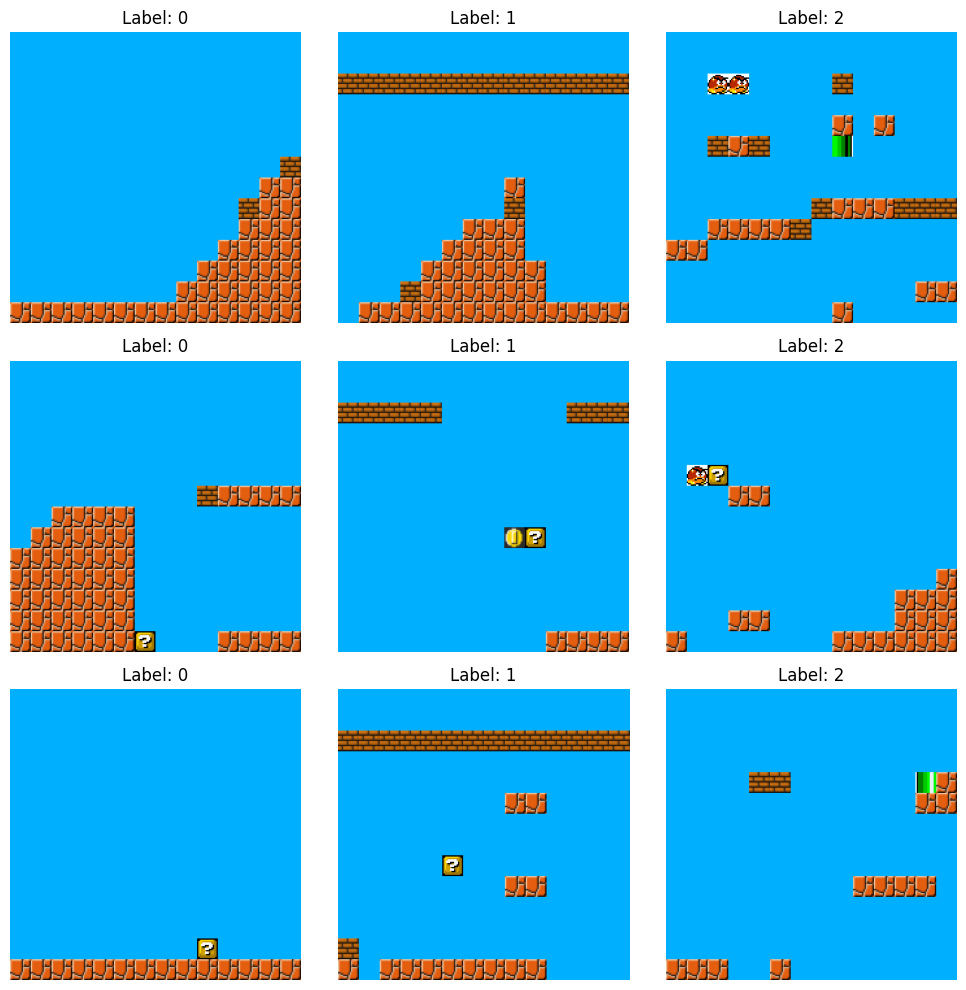

In [10]:
if not shouldTrain:
    # Generate samples for specific labels after loading the model
    # labels_to_generate = [0, 1, 2, 0, 1, 2, 0, 1, 2]  # Example labels
    # labels_to_generate = [0 for i in range(25)]  # Example labels
    labels_to_generate = [i%3 for i in range(25)]  # Example labels
    print(labels_to_generate)
    generated_samples = generate_conditional_samples(generator, labels_to_generate, device=device)
    
    # Visualize generated samples
    # Visualize generated samples
    # visualize_samples(samples=generated_samples, labels=labels_to_generate, num_samples=9,debug = False)
    # visualize_samples(samples=generated_samples, labels=labels_to_generate, num_samples=25,debug = True)
    visualize_mario_sample(samples=generated_samples, labels=labels_to_generate, num_samples=9,debug = False)

In [11]:
summaryModel = True
# summaryModel = False
if summaryModel:
    print(generator)
    

ConditionalGenerator(
  (label_emb): Embedding(3, 3)
  (main): Sequential(
    (0): ConvTranspose2d(103, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
  )
  (final): Sequential(
    (0): Conv2d(128, 1, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): Tanh()
  )
)


Label to Evaluate: 0
num_samples:       9


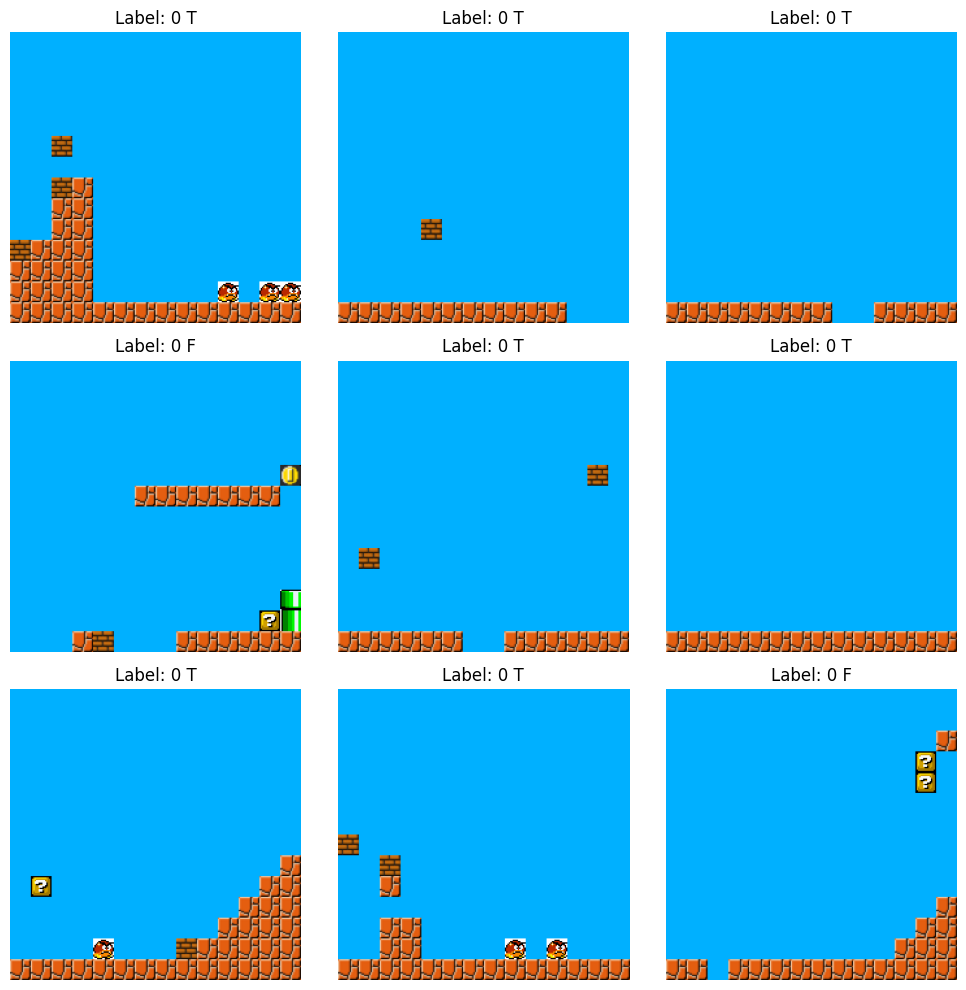

Verificación | Cuantos cumplen | Cuantos no cumplen
Primer bloque | 8 | 1
Bloques funcionales | 7 | 2
Camino valido| 9 | 0
Originalidad | 4 | 5
Map 1 passed all tests.
Map 2 passed all tests.
Map 3 passed all tests.
Map 5 passed all tests.
Map 6 passed all tests.
Map 7 passed all tests.
Map 8 passed all tests.
---------------------
Label to Evaluate: 1
num_samples:       9


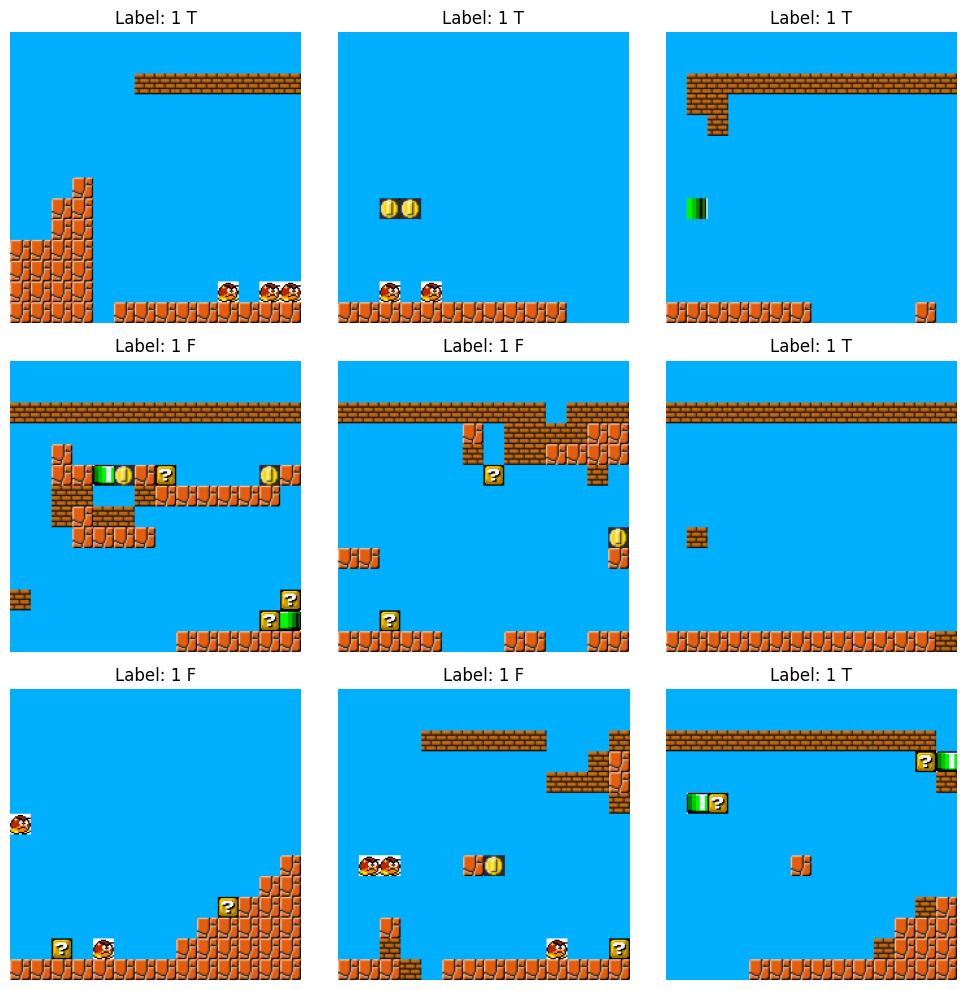

Verificación | Cuantos cumplen | Cuantos no cumplen
Primer bloque | 9 | 0
Bloques funcionales | 5 | 4
Camino valido| 9 | 0
Originalidad | 4 | 5
Map 1 passed all tests.
Map 2 passed all tests.
Map 3 passed all tests.
Map 6 passed all tests.
Map 9 passed all tests.
---------------------
Label to Evaluate: 2
num_samples:       9


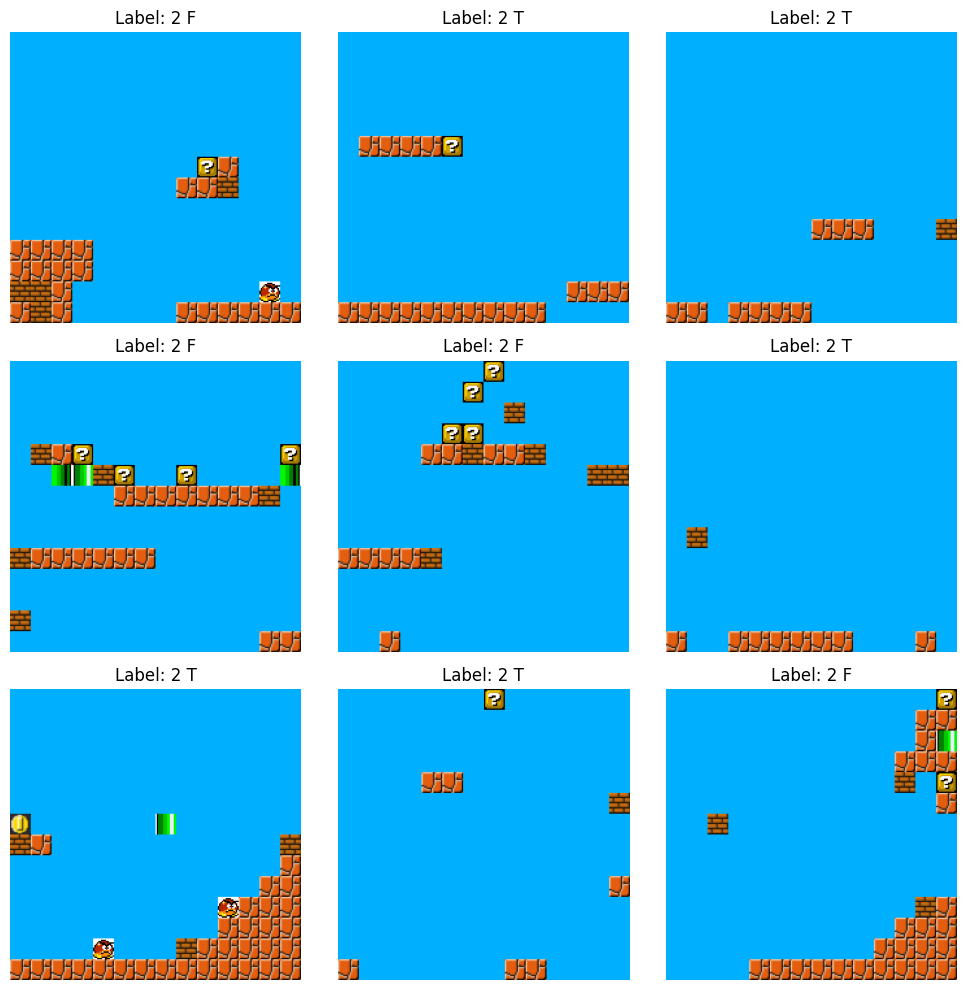

Verificación | Cuantos cumplen | Cuantos no cumplen
Primer bloque | 8 | 1
Bloques funcionales | 5 | 4
Camino valido| 9 | 0
Originalidad | 4 | 5
Map 2 passed all tests.
Map 3 passed all tests.
Map 6 passed all tests.
Map 7 passed all tests.
Map 8 passed all tests.
---------------------


In [12]:
evaluateModel = True
if evaluateModel:
    for label_to_test in range(3):
        print("Label to Evaluate:",label_to_test)
        labels = np.array([label_to_test for i in range(9)])
        evaluate_generated_maps(generator, 
                                num_samples = len(labels),
                                labels=labels, 
                                debug=False, 
                                debug_results=False, 
                                debug_visualize=True, 
                                debug_count=False, 
                                saveImg=False, 
                                savepath='./SavedImages',
                                label=f"{label_to_test}",
                                seed =4 )
        print("---------------------")
    # evaluate_generated_maps(generator, num_samples=16, debug=False, debug_results=False, debug_visualize=True, debug_count=False, seed = 42)

Label to Evaluate: 0
num_samples:       100


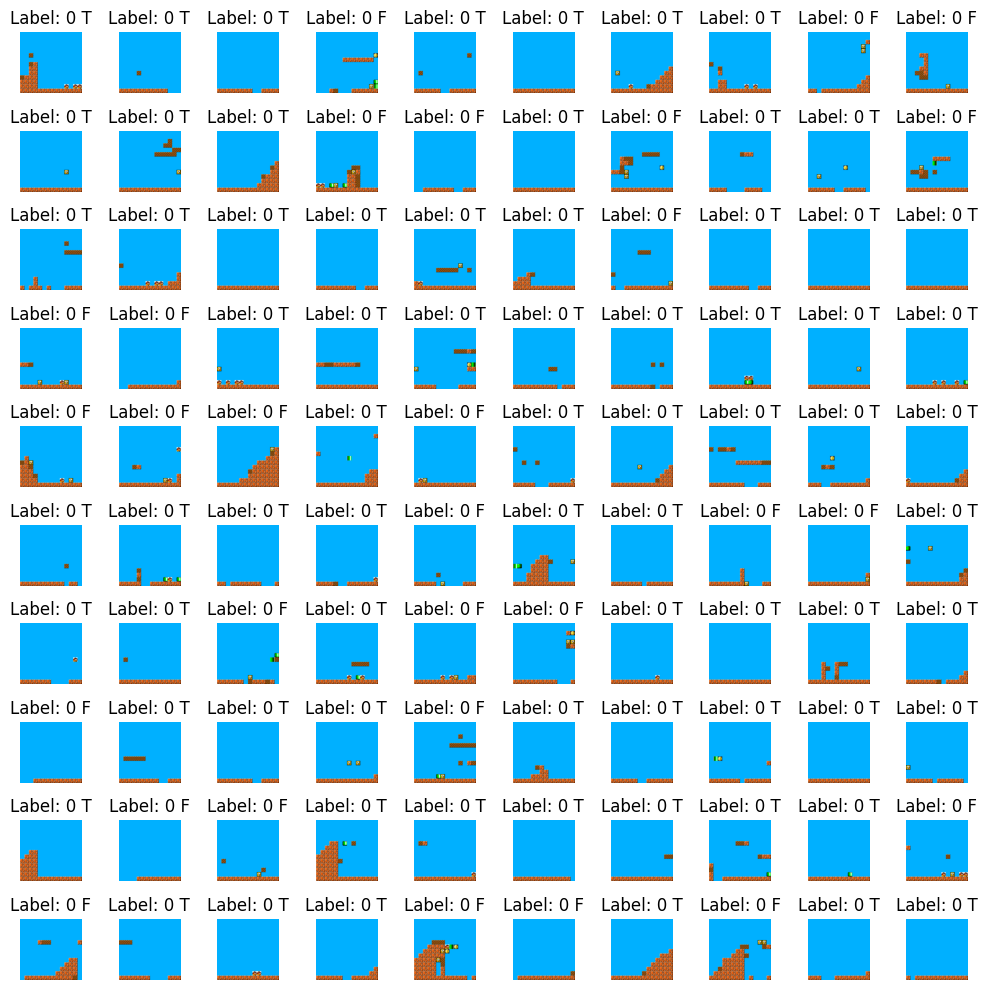

Verificación | Cuantos cumplen | Cuantos no cumplen
Primer bloque | 93 | 7
Bloques funcionales | 77 | 23
Camino valido| 100 | 0
Originalidad | 65 | 35
Map 1 passed all tests.
Map 2 passed all tests.
Map 3 passed all tests.
Map 5 passed all tests.
Map 6 passed all tests.
Map 7 passed all tests.
Map 8 passed all tests.
Map 11 passed all tests.
Map 12 passed all tests.
Map 13 passed all tests.
Map 16 passed all tests.
Map 18 passed all tests.
Map 19 passed all tests.
Map 21 passed all tests.
Map 22 passed all tests.
Map 23 passed all tests.
Map 24 passed all tests.
Map 25 passed all tests.
Map 26 passed all tests.
Map 28 passed all tests.
Map 29 passed all tests.
Map 30 passed all tests.
Map 33 passed all tests.
Map 34 passed all tests.
Map 35 passed all tests.
Map 36 passed all tests.
Map 37 passed all tests.
Map 38 passed all tests.
Map 39 passed all tests.
Map 40 passed all tests.
Map 44 passed all tests.
Map 46 passed all tests.
Map 47 passed all tests.
Map 48 passed all tests.
Map 49

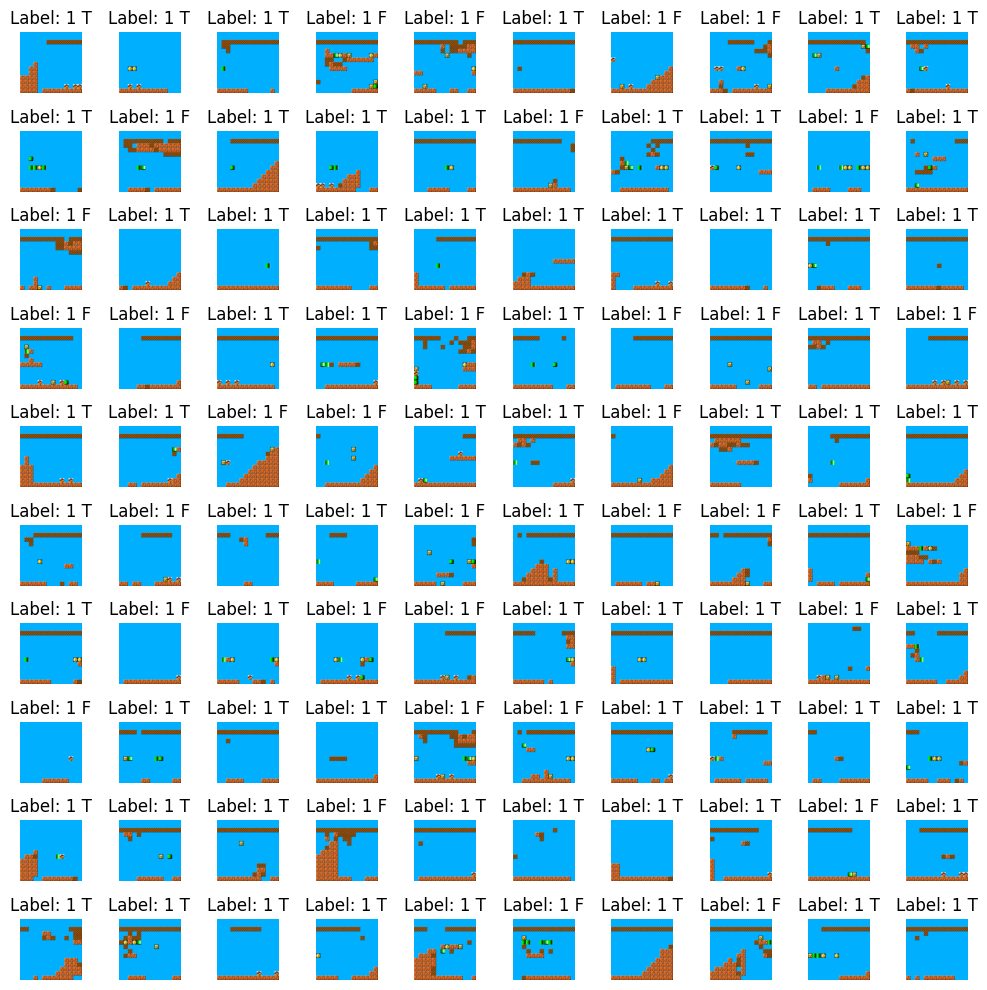

Verificación | Cuantos cumplen | Cuantos no cumplen
Primer bloque | 92 | 8
Bloques funcionales | 75 | 25
Camino valido| 99 | 1
Originalidad | 81 | 19
Map 1 passed all tests.
Map 2 passed all tests.
Map 3 passed all tests.
Map 6 passed all tests.
Map 9 passed all tests.
Map 10 passed all tests.
Map 11 passed all tests.
Map 13 passed all tests.
Map 14 passed all tests.
Map 15 passed all tests.
Map 17 passed all tests.
Map 18 passed all tests.
Map 20 passed all tests.
Map 22 passed all tests.
Map 23 passed all tests.
Map 24 passed all tests.
Map 25 passed all tests.
Map 26 passed all tests.
Map 27 passed all tests.
Map 28 passed all tests.
Map 29 passed all tests.
Map 30 passed all tests.
Map 33 passed all tests.
Map 34 passed all tests.
Map 36 passed all tests.
Map 39 passed all tests.
Map 41 passed all tests.
Map 42 passed all tests.
Map 45 passed all tests.
Map 46 passed all tests.
Map 48 passed all tests.
Map 49 passed all tests.
Map 50 passed all tests.
Map 51 passed all tests.
Map 5

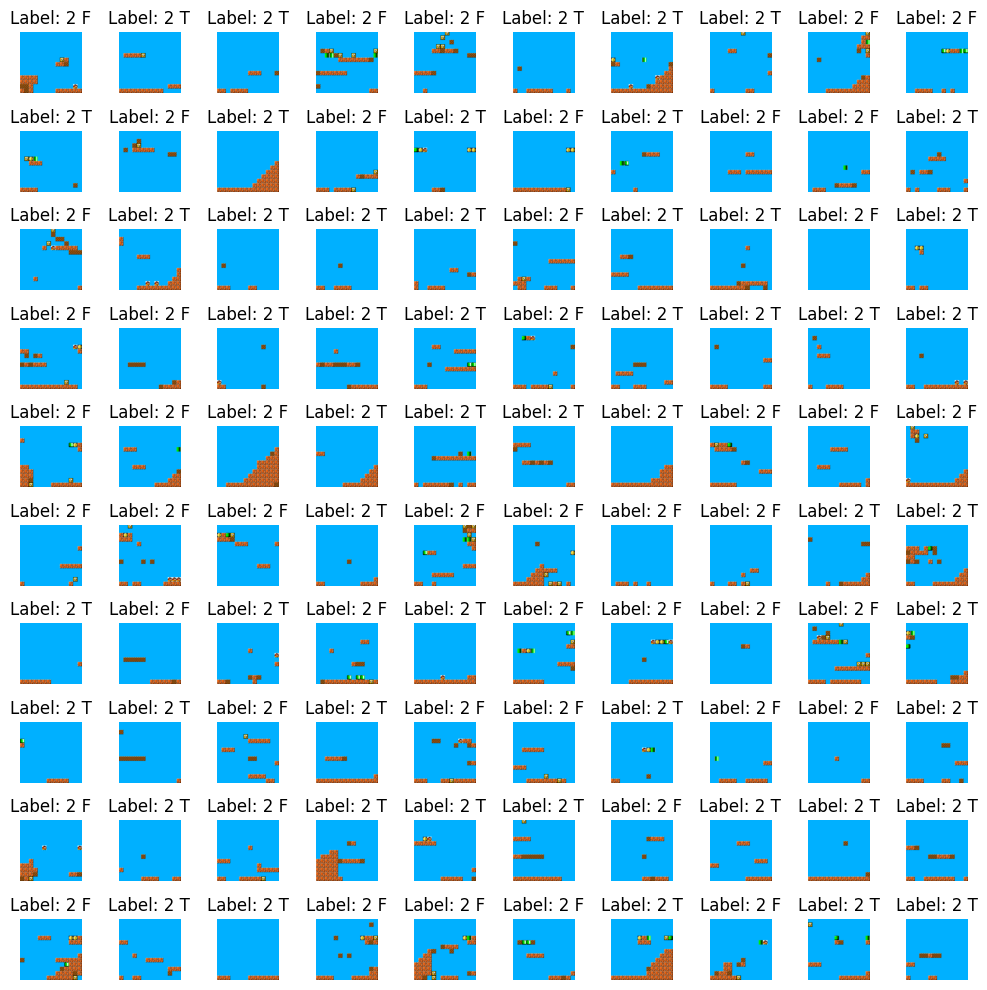

Verificación | Cuantos cumplen | Cuantos no cumplen
Primer bloque | 79 | 21
Bloques funcionales | 69 | 31
Camino valido| 100 | 0
Originalidad | 62 | 38
Map 2 passed all tests.
Map 3 passed all tests.
Map 6 passed all tests.
Map 7 passed all tests.
Map 8 passed all tests.
Map 11 passed all tests.
Map 13 passed all tests.
Map 15 passed all tests.
Map 17 passed all tests.
Map 20 passed all tests.
Map 22 passed all tests.
Map 23 passed all tests.
Map 24 passed all tests.
Map 25 passed all tests.
Map 27 passed all tests.
Map 28 passed all tests.
Map 30 passed all tests.
Map 33 passed all tests.
Map 34 passed all tests.
Map 35 passed all tests.
Map 37 passed all tests.
Map 38 passed all tests.
Map 39 passed all tests.
Map 40 passed all tests.
Map 44 passed all tests.
Map 45 passed all tests.
Map 46 passed all tests.
Map 47 passed all tests.
Map 54 passed all tests.
Map 59 passed all tests.
Map 60 passed all tests.
Map 61 passed all tests.
Map 63 passed all tests.
Map 65 passed all tests.
Map

In [13]:
evaluateModel = True
if evaluateModel:
    for label_to_test in range(3):
        print("Label to Evaluate:",label_to_test)
        labels = np.array([label_to_test for i in range(100)])
        evaluate_generated_maps(generator, 
                                num_samples = len(labels),
                                labels=labels, 
                                debug=False, 
                                debug_results=False, 
                                debug_visualize=True, 
                                debug_count=False, 
                                saveImg=False, 
                                savepath='./SavedImages',
                                label=f"{label_to_test}",
                                seed =4 )
        print("---------------------")
    # evaluate_generated_maps(generator, num_samples=16, debug=False, debug_results=False, debug_visualize=True, debug_count=False, seed = 42)